In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_c1_t = pd.read_csv('07-08-2024_19-38-10_Coil_table_data.csv', parse_dates = True, index_col=0)  # coil #1 table data
df_c1_s = pd.read_csv('07-08-2024_20-53-50_Mangnetometer_sensor_data.csv', parse_dates = True, date_format="%d-%m-%Y_%H-%M-%S", index_col=0 )  # coil #1 sensor data

# converting index to datetime index
df_c1_t.index = pd.to_datetime(df_c1_t.index, format="%d-%m-%Y_%H-%M-%S")
df_c1_s.index = pd.to_datetime(df_c1_s.index)

# removing redundunt columns
df_c1_t.drop(columns=['EEpose_0',	'EEpose_1',	'EEpose_2',	'EEpose_3',	'EEpose_4',	'EEpose_5',	'EEpose_6',	'EEpose_7',	'EEpose_8',	'EEpose_9',	'EEpose_10', 'EEpose_11', 'EEpose_12',	'EEpose_13', 'EEpose_14', 'EEpose_15', 'Unnamed: 89'], inplace=True)

# resampling the data for 1sec freq
df_c1_t = df_c1_t.resample('s').mean()
df_c1_s = df_c1_s.resample('s').mean()

df_c1_t = df_c1_t.dropna()

# join the sensor and table dataframes
df1 = df_c1_t.join(df_c1_s, how="inner")  # intersecion of the two dataframes


C:\Users\Gediy\AppData\Local\Temp\ipykernel_33232\1635709502.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_c1_t = pd.read_csv('07-08-2024_19-38-10_Coil_table_data.csv', parse_dates = True, index_col=0)  # coil #1 table data


In [3]:
# divide the data into single sweeps across the 3D space
df1_dic = {}
for i in range(-15,17,2):
    mask = df1['cmdCoilCurrent_5(A)'] == i
    df1_dic[i] = df1[mask]

In [4]:
for i in range(-15,17,2):
       
    # Calculate the time delta between consecutive rows
    df1_dic[i]['delta'] = df1_dic[i].index.to_series().diff()

    # Create a mask for rows where the time delta is greater than 1 second
    mask = df1_dic[i]['delta'] > pd.Timedelta(seconds=2)

    specific_datetime = df1_dic[i].index[mask]

    # timesteps to go backwards
    time_steps = df1_dic[i]['delta'][mask] - pd.Timedelta(seconds=2)

    # Initialize a list to accumulate new rows
    new_rows_list = []

    # Loop through each specific datetime and corresponding time step
    for dt, step in zip(specific_datetime, time_steps):
        start = dt - step
        end = dt - pd.Timedelta(seconds=1)

        # Generate a date range with the new rows
        date_range = pd.date_range(start=start, end=end, freq='s')

        # Create DataFrame with new rows
        new_rows = pd.DataFrame(index=date_range, columns=df1_dic[i].columns)

        # Append new rows to the list
        new_rows_list.append(new_rows)

    if (len(new_rows_list) > 0):
        # Concatenate all new rows and append them to the original DataFrame
        new_rows_combined = pd.concat(new_rows_list)
        df1_dic[i] = pd.concat([df1_dic[i], new_rows_combined])

    # Sort the DataFrame by index
    df1_dic[i] = df1_dic[i].sort_index()

    #########


    # Calculate the time delta between consecutive rows
    df1_dic[i]['delta'] = df1_dic[i].index.to_series().diff()

    # Create a mask for rows where the time delta is greater than 1 second
    mask = df1_dic[i]['delta'] > pd.Timedelta(seconds=1)

    # keep 3 rows preceding them
    rows_to_keep = df1_dic[i].index[mask].to_series().index - pd.Timedelta(seconds=3)

    df1_dic[i] = df1_dic[i].loc[rows_to_keep]

C:\Users\Gediy\AppData\Local\Temp\ipykernel_33232\789849509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_dic[i]['delta'] = df1_dic[i].index.to_series().diff()
C:\Users\Gediy\AppData\Local\Temp\ipykernel_33232\789849509.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df1_dic[i] = pd.concat([df1_dic[i], new_rows_combined])
C:\Users\Gediy\AppData\Local\Temp\ipykernel_33232\789849509.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. I

In [5]:
df1_dic[-5][['cmdCoilCurrent_2(A)','Sensor_1_dir_x','Sensor_1_dir_y','Sensor_1_dir_z']]


,cmdCoilCurrent_2(A),Sensor_1_dir_x,Sensor_1_dir_y,Sensor_1_dir_z
2024-08-07 20:01:35,0.0,0.219634,0.220521,0.040948
2024-08-07 20:01:39,0.0,0.060180,0.219995,0.040097
2024-08-07 20:01:43,0.0,-0.099684,0.220210,0.039876
2024-08-07 20:01:47,0.0,-0.100158,0.060021,0.039645
2024-08-07 20:01:51,0.0,0.059890,0.059942,0.040088
...,...,...,...,...
2024-08-07 20:05:28,0.0,0.059982,0.059893,0.280121
2024-08-07 20:05:32,0.0,0.220038,0.059966,0.279860
2024-08-07 20:05:36,0.0,0.220318,-0.097476,0.276131
2024-08-07 20:05:40,0.0,0.059946,-0.100291,0.278364


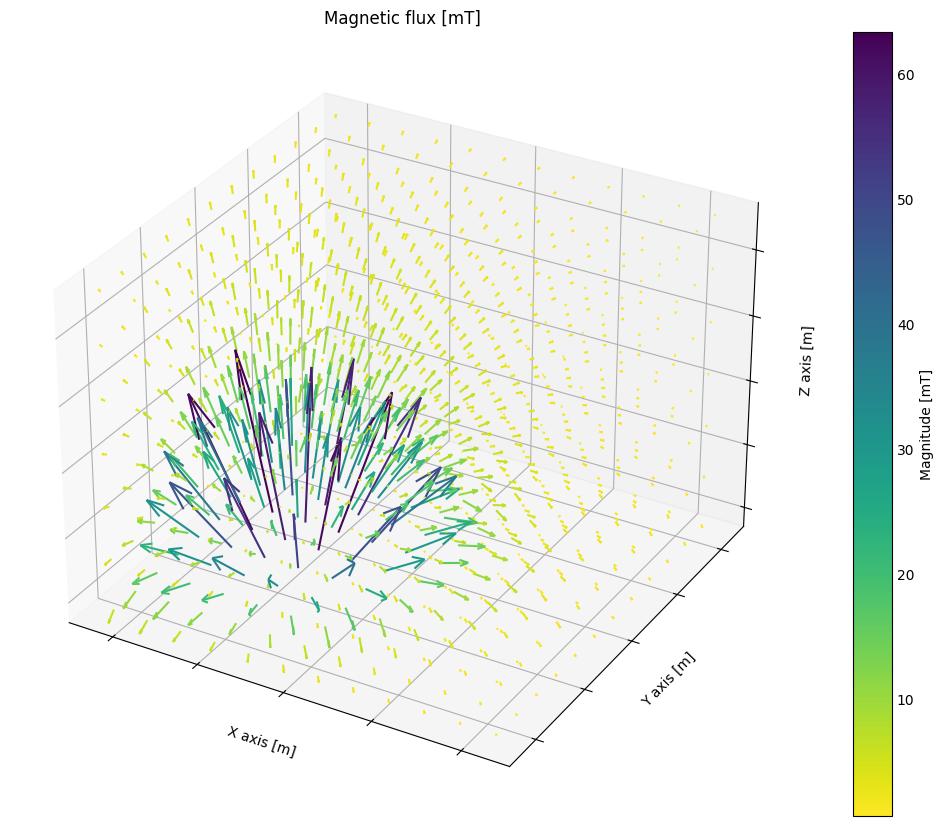

In [6]:
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('_mpl-gallery')

# Make data
n = 4
x = df1_dic[13][['Sensor_1_dir_x','Sensor_2_dir_x','Sensor_3_dir_x','Sensor_4_dir_x',
                'Sensor_5_dir_x','Sensor_6_dir_x','Sensor_7_dir_x','Sensor_8_dir_x',
                'Sensor_9_dir_x','Sensor_10_dir_x','Sensor_11_dir_x','Sensor_12_dir_x',
                'Sensor_13_dir_x','Sensor_14_dir_x','Sensor_15_dir_x','Sensor_16_dir_x']].values.reshape(-1, 1)
y = df1_dic[13][['Sensor_1_dir_y','Sensor_2_dir_y','Sensor_3_dir_y','Sensor_4_dir_y',
                'Sensor_5_dir_y','Sensor_6_dir_y','Sensor_7_dir_y','Sensor_8_dir_y',
                'Sensor_9_dir_y','Sensor_10_dir_y','Sensor_11_dir_y','Sensor_12_dir_y',
                'Sensor_13_dir_y','Sensor_14_dir_y','Sensor_15_dir_y','Sensor_16_dir_y']].values.reshape(-1, 1)
z = df1_dic[13][['Sensor_1_dir_z','Sensor_2_dir_z','Sensor_3_dir_z','Sensor_4_dir_z',
                'Sensor_5_dir_z','Sensor_6_dir_z','Sensor_7_dir_z','Sensor_8_dir_z',
                'Sensor_9_dir_z','Sensor_10_dir_z','Sensor_11_dir_z','Sensor_12_dir_z',
                'Sensor_13_dir_z','Sensor_14_dir_z','Sensor_15_dir_z','Sensor_16_dir_z']].values.reshape(-1, 1)

# X, Y, Z = np.meshgrid(x, y, z)

U = df1_dic[13][['sensor_1_X [mT]','sensor_2_X [mT]','sensor_3_X [mT]','sensor_4_X [mT]',
                'sensor_5_X [mT]','sensor_6_X [mT]','sensor_7_X [mT]','sensor_8_X [mT]',
                'sensor_9_X [mT]','sensor_10_X [mT]','sensor_11_X [mT]','sensor_12_X [mT]',
                'sensor_13_X [mT]','sensor_14_X [mT]','sensor_15_X [mT]','sensor_16_X [mT]',]].values.reshape(-1, 1)

V = df1_dic[13][['sensor_1_Y [mT]','sensor_2_Y [mT]','sensor_3_Y [mT]','sensor_4_Y [mT]',
                'sensor_5_Y [mT]','sensor_6_Y [mT]','sensor_7_Y [mT]','sensor_8_Y [mT]',
                'sensor_9_Y [mT]','sensor_10_Y [mT]','sensor_11_Y [mT]','sensor_12_Y [mT]',
                'sensor_13_Y [mT]','sensor_14_Y [mT]','sensor_15_Y [mT]','sensor_16_Y [mT]',]].values.reshape(-1, 1)


W = df1_dic[13][['sensor_1_Z [mT]','sensor_2_Z [mT]','sensor_3_Z [mT]','sensor_4_Z [mT]',
                'sensor_5_Z [mT]','sensor_6_Z [mT]','sensor_7_Z [mT]','sensor_8_Z [mT]',
                'sensor_9_Z [mT]','sensor_10_Z [mT]','sensor_11_Z [mT]','sensor_12_Z [mT]',
                'sensor_13_Z [mT]','sensor_14_Z [mT]','sensor_15_Z [mT]','sensor_16_Z [mT]',]].values.reshape(-1, 1)

# Compute the magnitude of the vectors
magnitude = np.sqrt(U**2 + V**2 + W**2)

# Normalize the magnitudes to the range [0, 1]
norm = Normalize(vmin=magnitude.min(), vmax=magnitude.max())

# Create a colormap object
colormap = cm.viridis_r  # You can choose other colormaps like 'plasma', 'inferno', etc.


# Plot
# Create a figure with custom size
fig = plt.figure(figsize=(12, 8))  # Set figure size
ax = fig.add_subplot(111, projection='3d')

plot = ax.quiver(x, y, z, U, V, W, length=0.002, normalize= False, color=colormap(norm(magnitude)))

# Add a colorbar to show the mapping of magnitudes to colors
mappable = cm.ScalarMappable(norm=norm, cmap=colormap)
cbar = plt.colorbar(mappable, ax=ax)
cbar.set_label('Magnitude [mT]')

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[],
       xlabel = ('X axis [m]'),
       ylabel = ('Y axis [m]'),
       zlabel = ('Z axis [m]'),
       title = ('Magnetic flux [mT]'))

plt.show()

In [7]:
#save data
# Create an empty DataFrame
concatenated_df1 = pd.DataFrame()

for i in range(-15,17,2):
    # Concatenate DataFrames along rows (default axis=0)
    concatenated_df1 = pd.concat([concatenated_df1, df1_dic[i]], axis=0)
    
# Save the concatenated DataFrame to a CSV file
concatenated_df1.to_csv('Processed_data/coil5_data.csv', index=True)  # index=True to include datetime index